# ***Computing the center of mass of a particle system using Graph Neural Networks***

### Create some set of particles with random positions and masses. Implement several Graph Neural Networks models to predict the center of mass of each system.

Author: Pablo Villanueva Domingo

Date: October 2020

# Preliminaries

In [1]:
# Install required pytorch geometric and related packages
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git
!pip install -q torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html

# Import required packages
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader, Dataset
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric import nn
from torch_cluster import knn_graph

# Random seed
torch.manual_seed(12345)
np.random.seed(12345)

# Some functions to build graphs

In [2]:
# Creates a complete graph. For a given set of nodes, creates a set of edges connecting all the nodes
def build_complete_graph(num_nodes):

    # Initialize edge index matrix
    E = torch.zeros((2, num_nodes * (num_nodes - 1)), dtype=torch.long)
    
    # Populate 1st row
    for node in range(num_nodes):
        for neighbor in range(num_nodes - 1):
            E[0, node * (num_nodes - 1) + neighbor] = node

    # Populate 2nd row
    neighbors = []
    for node in range(num_nodes):
        neighbors.append(list(np.arange(node)) + list(np.arange(node+1, num_nodes)))
    E[1, :] = torch.Tensor([item for sublist in neighbors for item in sublist])
    
    return E

# Creates an empty graph, without edges
def build_empty_graph():

    edge_index = torch.tensor([[], []], dtype=torch.int64)
    return edge_index

# Compute the Center of Mass, given x = [x_1, x_2, mass]
def COM(x):

  xx, yy, m = x[:,0], x[:,1], x[:,2]

  x_com = np.sum(xx*m) / np.sum(m)
  y_com = np.sum(yy*m) / np.sum(m)

  return torch.tensor([[x_com, y_com]], dtype=torch.float)

# Creates particles with random positions and masses. If k!=None, it uses kNN to create edges. Take a complete graph otherwise
def random_particles(num_nodes, k=None):

  x = np.random.randn(num_nodes, 3)  # 2D position + mass
  x[:,2] += 10. # mass must be positive (I could improve this)
               
  if k==None:
    edge_index = build_complete_graph(num_nodes=num_nodes)    # Complete graph
    #edge_index = build_empty_graph()             # Uncomment for an empty graph
  else:
    pos = x[:,:2]
    edge_index = knn_graph(torch.tensor(pos, dtype=torch.float32), k=k, loop=True)

  data = Data(x=torch.tensor(x, dtype=torch.float32) , edge_index=edge_index, y=COM(x) )

  return data


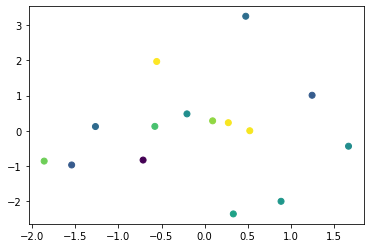

In [3]:
data = random_particles(15)
xx, yy, m = data.x[:,0], data.x[:,1], data.x[:,2]
plt.scatter(xx, yy, c=m)

# Creating the dataset

In [4]:
# Parameters
num_graphs = 200
epochs = 150
batch_size = 32
k_nn = 6  # None if complete graph

# Creates a dataset with num_graphs graphs. Each graph has a random number of nodes between 10 and 100
def many_graphs(num_graphs, k_nn=None):

  dataset = []
  for i in range(num_graphs):
    data = random_particles(np.random.randint(10,100), k=k_nn)
    dataset.append(data)

  return dataset

# Define training and testing datasets and dataloaders
dataset = many_graphs(num_graphs=num_graphs, k_nn=k_nn)

train_dataset = dataset[:int(0.75*len(dataset))]
test_dataset = dataset[int(0.75*len(dataset)):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Number of training graphs: 150
Number of test graphs: 50
Step 1:
Number of graphs in the current batch: 32
Batch(batch=[1568], edge_index=[2, 9408], x=[1568, 3], y=[32, 2])

Step 2:
Number of graphs in the current batch: 32
Batch(batch=[1496], edge_index=[2, 8976], x=[1496, 3], y=[32, 2])

Step 3:
Number of graphs in the current batch: 32
Batch(batch=[1801], edge_index=[2, 10806], x=[1801, 3], y=[32, 2])

Step 4:
Number of graphs in the current batch: 32
Batch(batch=[1567], edge_index=[2, 9402], x=[1567, 3], y=[32, 2])

Step 5:
Number of graphs in the current batch: 22
Batch(batch=[1358], edge_index=[2, 8148], x=[1358, 3], y=[22, 2])



# Networks

In [5]:
# Fully Connected Network
class FCN(torch.nn.Module):
    def __init__(self, num_node_features=3, hidden_channels=32):
        super(FCN, self).__init__()

        self.lin1 = Linear(num_node_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):  # Edges not used!

        # 1. Obtain node embeddings
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.2)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.2)
        x = self.lin3(x)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        return x

model = FCN(num_node_features=3, hidden_channels=32)
print(model)

FCN(
  (lin1): Linear(in_features=3, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
)


In [6]:
# Graph Neural Net using GCN layers
class GCN(torch.nn.Module):
    def __init__(self, num_node_features=3, hidden_channels=32):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(num_node_features=3, hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In [7]:
# PointNet++ neural net using the PointNet layer already implemented in pytorch-geometric
class PointNetOld(torch.nn.Module):
    def __init__(self, num_node_features=3, hidden_channels=32):
        super(PointNetOld, self).__init__()

        mlp1 = torch.nn.Sequential(Linear(num_node_features+2, hidden_channels),
                              torch.nn.ReLU(),
                              Linear(hidden_channels, hidden_channels))
        self.conv1 = nn.PointConv( mlp1 )
        mlp2 = torch.nn.Sequential(Linear(hidden_channels+2, hidden_channels),
                              torch.nn.ReLU(),
                              Linear(hidden_channels, hidden_channels))
        self.conv2 = nn.PointConv( mlp2 )

        self.lin = Linear(hidden_channels, 2)
        
    def forward(self, x, edge_index, batch):

        # Get edges by computing the kNN graph using positions
        pos = x[:,:2]
        edge_index = knn_graph(pos, k=6, batch=batch, loop=True)
        
        # Start bipartite message passing
        h = self.conv1(x=x, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(x=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # Mean global Pooling.
        h = global_mean_pool(h, batch)  # [num_examples, hidden_channels]
        
        # Final linear layer
        return self.lin(h)

In [8]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_cluster import knn_graph

# PointNet layer (from pytorch-geometric documentation examples)
class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super(PointNetLayer, self).__init__('max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=2).
        self.mlp = Sequential(Linear(in_channels+2, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        #print(h_j.shape, input.shape)

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        #print(h_j.shape, input.shape)

        return self.mlp(input)  # Apply our final MLP.

# Graph Neural Net using PointNet layers
class PointNet(torch.nn.Module):
    def __init__(self, num_node_features=3, hidden_channels=32):
        super(PointNet, self).__init__()

        self.conv1 = PointNetLayer(num_node_features, hidden_channels)
        self.conv2 = PointNetLayer(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        
    def forward(self, x, edge_index, batch):

        # Get edges by computing the kNN graph using positions
        pos = x[:,:2]
        edge_index = knn_graph(pos, k=6, batch=batch, loop=True)
        
        # Start bipartite message passing
        h = self.conv1(h=x, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # Mean global pooling
        h = nn.global_mean_pool(h, batch)  # [num_examples, hidden_channels]
        
        # Final linear layer
        return self.lin(h)


# Training routines

In [9]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Train on one epoch
def train(loader, model, optimizer, criterion):
    model.train()

    loss_tot = 0
    for data in loader:  # Iterate in batches over the training dataset.
         
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         loss_tot += loss

    return loss_tot/len(loader)

# Test the model
def test(loader, model, criterion):
     model.eval()

     errs = []
     loss_tot = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         err = (out - data.y)#/data.y
         errs.append( np.abs(err.detach().numpy()).mean(axis=0) )
         loss = criterion(out, data.y)
         loss_tot += loss
      
     return loss_tot/len(loader), np.array(errs).mean(axis=0)

# Training/testing routine
def training_routine(model):

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.MSELoss()

  train_losses, test_losses = [], []
  for epoch in range(1, epochs+1):
      train_loss = train(train_loader, model, optimizer, criterion)
      test_loss, err = test(test_loader, model, criterion)
      train_losses.append(train_loss); test_losses.append(test_loss)
      print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Absolute error: {err.mean():.4f}')

  plt.plot(range(epochs), np.array(train_losses), "r-",label="Training")
  plt.plot(range(epochs), np.array(test_losses), "b:",label="Testing")
  plt.legend()
  plt.yscale("log")

<IPython.core.display.Javascript object>

# Training different models

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([22, 2])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([18, 2])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(

Epoch: 001, Train Loss: 0.2539, Test Loss: 0.2834, Absolute error: 0.5027
Epoch: 002, Train Loss: 0.1146, Test Loss: 0.0520, Absolute error: 0.1772
Epoch: 003, Train Loss: 0.0705, Test Loss: 0.0395, Absolute error: 0.1505
Epoch: 004, Train Loss: 0.0342, Test Loss: 0.0295, Absolute error: 0.1365
Epoch: 005, Train Loss: 0.0351, Test Loss: 0.0377, Absolute error: 0.1622
Epoch: 006, Train Loss: 0.0354, Test Loss: 0.0321, Absolute error: 0.1441
Epoch: 007, Train Loss: 0.0306, Test Loss: 0.0258, Absolute error: 0.1231
Epoch: 008, Train Loss: 0.0288, Test Loss: 0.0247, Absolute error: 0.1145
Epoch: 009, Train Loss: 0.0282, Test Loss: 0.0252, Absolute error: 0.1146
Epoch: 010, Train Loss: 0.0279, Test Loss: 0.0249, Absolute error: 0.1161
Epoch: 011, Train Loss: 0.0283, Test Loss: 0.0249, Absolute error: 0.1171
Epoch: 012, Train Loss: 0.0270, Test Loss: 0.0253, Absolute error: 0.1202
Epoch: 013, Train Loss: 0.0270, Test Loss: 0.0254, Absolute error: 0.1198
Epoch: 014, Train Loss: 0.0277, Test L

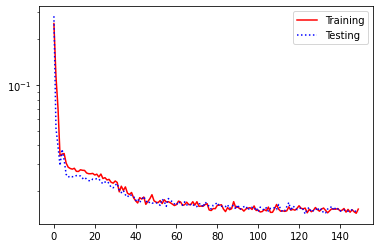

In [10]:
# Fully connected network
model = FCN()
training_routine(model)

Epoch: 001, Train Loss: 0.6397, Test Loss: 0.0363, Absolute error: 0.1582
Epoch: 002, Train Loss: 0.0940, Test Loss: 0.0406, Absolute error: 0.1530
Epoch: 003, Train Loss: 0.0500, Test Loss: 0.0312, Absolute error: 0.1434
Epoch: 004, Train Loss: 0.0380, Test Loss: 0.0299, Absolute error: 0.1329
Epoch: 005, Train Loss: 0.0276, Test Loss: 0.0262, Absolute error: 0.1199
Epoch: 006, Train Loss: 0.0299, Test Loss: 0.0252, Absolute error: 0.1191
Epoch: 007, Train Loss: 0.0280, Test Loss: 0.0258, Absolute error: 0.1222
Epoch: 008, Train Loss: 0.0268, Test Loss: 0.0255, Absolute error: 0.1249
Epoch: 009, Train Loss: 0.0284, Test Loss: 0.0245, Absolute error: 0.1223
Epoch: 010, Train Loss: 0.0268, Test Loss: 0.0259, Absolute error: 0.1245
Epoch: 011, Train Loss: 0.0271, Test Loss: 0.0255, Absolute error: 0.1221
Epoch: 012, Train Loss: 0.0255, Test Loss: 0.0253, Absolute error: 0.1199
Epoch: 013, Train Loss: 0.0259, Test Loss: 0.0242, Absolute error: 0.1175
Epoch: 014, Train Loss: 0.0262, Test L

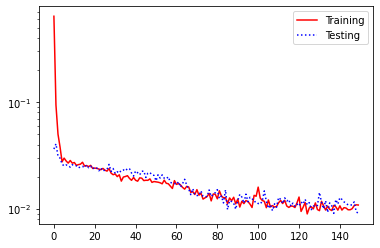

In [11]:
# Graph convolutional network
model = GCN()
training_routine(model)

Epoch: 001, Train Loss: 0.0376, Test Loss: 0.0263, Absolute error: 0.1230
Epoch: 002, Train Loss: 0.0292, Test Loss: 0.0270, Absolute error: 0.1255
Epoch: 003, Train Loss: 0.0289, Test Loss: 0.0261, Absolute error: 0.1231
Epoch: 004, Train Loss: 0.0288, Test Loss: 0.0268, Absolute error: 0.1266
Epoch: 005, Train Loss: 0.0283, Test Loss: 0.0265, Absolute error: 0.1232
Epoch: 006, Train Loss: 0.0293, Test Loss: 0.0258, Absolute error: 0.1189
Epoch: 007, Train Loss: 0.0272, Test Loss: 0.0270, Absolute error: 0.1289
Epoch: 008, Train Loss: 0.0277, Test Loss: 0.0254, Absolute error: 0.1203
Epoch: 009, Train Loss: 0.0276, Test Loss: 0.0259, Absolute error: 0.1245
Epoch: 010, Train Loss: 0.0263, Test Loss: 0.0245, Absolute error: 0.1177
Epoch: 011, Train Loss: 0.0258, Test Loss: 0.0263, Absolute error: 0.1268
Epoch: 012, Train Loss: 0.0263, Test Loss: 0.0229, Absolute error: 0.1125
Epoch: 013, Train Loss: 0.0229, Test Loss: 0.0231, Absolute error: 0.1113
Epoch: 014, Train Loss: 0.0247, Test L

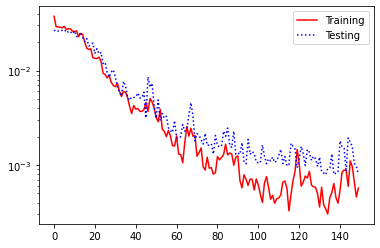

In [12]:
# PointNet++
model = PointNet()
training_routine(model)

Epoch: 001, Train Loss: 0.0310, Test Loss: 0.0261, Absolute error: 0.1193
Epoch: 002, Train Loss: 0.0289, Test Loss: 0.0268, Absolute error: 0.1266
Epoch: 003, Train Loss: 0.0288, Test Loss: 0.0261, Absolute error: 0.1231
Epoch: 004, Train Loss: 0.0289, Test Loss: 0.0260, Absolute error: 0.1231
Epoch: 005, Train Loss: 0.0281, Test Loss: 0.0258, Absolute error: 0.1217
Epoch: 006, Train Loss: 0.0285, Test Loss: 0.0263, Absolute error: 0.1248
Epoch: 007, Train Loss: 0.0268, Test Loss: 0.0263, Absolute error: 0.1261
Epoch: 008, Train Loss: 0.0280, Test Loss: 0.0251, Absolute error: 0.1191
Epoch: 009, Train Loss: 0.0269, Test Loss: 0.0249, Absolute error: 0.1212
Epoch: 010, Train Loss: 0.0246, Test Loss: 0.0248, Absolute error: 0.1178
Epoch: 011, Train Loss: 0.0218, Test Loss: 0.0217, Absolute error: 0.1100
Epoch: 012, Train Loss: 0.0193, Test Loss: 0.0260, Absolute error: 0.1228
Epoch: 013, Train Loss: 0.0192, Test Loss: 0.0191, Absolute error: 0.0972
Epoch: 014, Train Loss: 0.0151, Test L

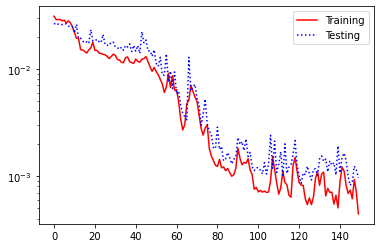

In [13]:
# PointNet++ (other implementation)
model = PointNetOld()
training_routine(model)

# Visualizing the results

Error [0.07727083 0.03262657] Output: [ 0.18623681 -0.38187534] Real COM: [ 0.10896599 -0.4145019 ]


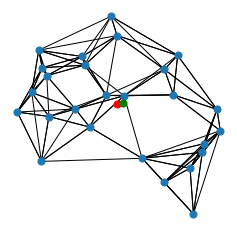

Error [0.01345046 0.03324268] Output: [-0.00083083  0.04257937] Real COM: [-0.01428129  0.07582205]


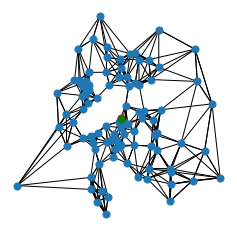

Error [0.0111705  0.01325714] Output: [0.00696426 0.03945991] Real COM: [0.01813477 0.02620277]


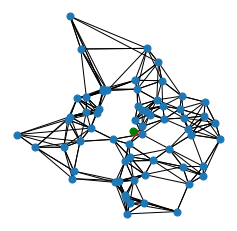

Error [0.00760679 0.02309776] Output: [-0.0669829  -0.00575213] Real COM: [-0.05937611  0.01734563]


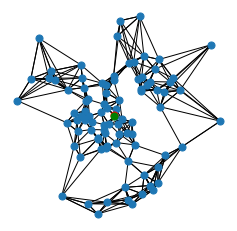

Error [0.01660533 0.002271  ] Output: [ 0.02755204 -0.00491397] Real COM: [ 0.04415737 -0.00264297]


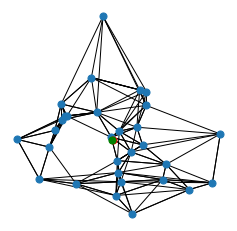

Error [0.04300532 0.00445404] Output: [0.19740228 0.05499798] Real COM: [0.2404076  0.05945202]


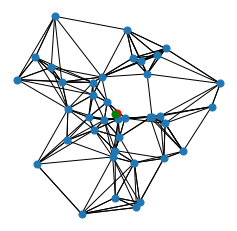

Error [0.0219257  0.01764897] Output: [-0.13721249  0.07557958] Real COM: [-0.15913819  0.0579306 ]


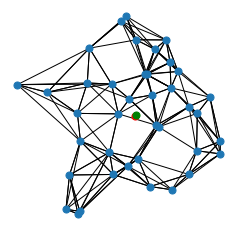

Error [0.01929031 0.09834805] Output: [0.21123476 0.26814398] Real COM: [0.19194445 0.16979593]


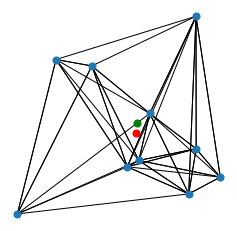

Error [0.00587854 0.03355529] Output: [-0.05308431  0.04359078] Real COM: [-0.04720577  0.01003549]


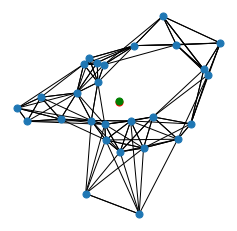

Error [0.01911335 0.0617383 ] Output: [-0.03756861 -0.22688241] Real COM: [-0.01845526 -0.2886207 ]


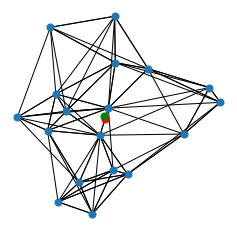

Mean error [0.02353171 0.03202398]


In [14]:
# Visualization routine
def visualize_points(data, edge_index=None, index=None, show_com_true=1, outmodel=None):

    pos = data.x[:,:2]
    c_o_m = data.y
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    if show_com_true:
       plt.scatter(c_o_m[0,0], c_o_m[0,1], s=50, zorder=1000, color="red")
    if outmodel is not None:
       outmodel = outmodel.detach().numpy()
       plt.scatter(outmodel[0,0], outmodel[0,1], s=50, zorder=1000, color="green")


    plt.axis('off')
    plt.show()


# Plot some samples
errs = []
#for i in range(10):
for i in range(10):

  data = test_dataset[i]
  data.pos = data.x[:,:2]
  data.edge_index = knn_graph(data.pos, k=6)

  pseudobatch = torch.from_numpy(np.zeros(len(data.x))).type(torch.int64)
  out = model(data.x, data.edge_index, pseudobatch)

  outmodel = out.detach().numpy()
  c_o_m = data.y
  err = (outmodel[0]-c_o_m[0].detach().numpy())
  errs.append(np.abs(err))
  print("Error",np.abs(err), "Output:", outmodel[0], "Real COM:", c_o_m[0].detach().numpy())

  visualize_points(data, edge_index=data.edge_index, outmodel=out)
print("Mean error",np.array(errs).mean(axis=0))